## Get the Data

Welcome to Machine Learning Housing Corp.! Our task is to predict median house values in Californian districts, given a number of features from these districts. 

## Download the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile 
import urllib.request


def load_housing_data():
    tarball_path = Path("dataset/housing.tgz")
    if not tarball_path.is_file():
        Path("dataset").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="dataset")
    return pd.read_csv(Path("dataset/housing/housing.csv"))

housing = load_housing_data()
        

### Take a Quick Look at the Data Structure

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* **defines the save_fig() function which is used through this notebook to save the figures in high-res for the book.**

In [6]:
import matplotlib.pyplot as plt


IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

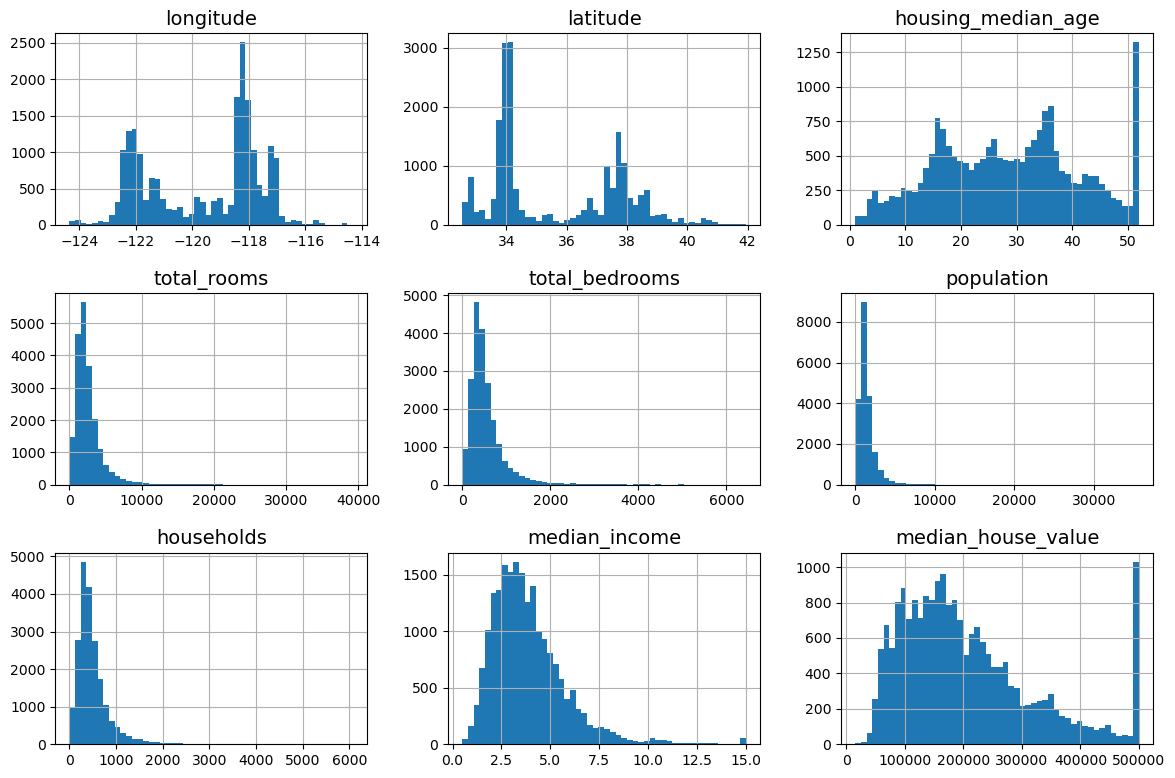

In [7]:
# extra code – the next 5 lines define the default font sizes

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")
plt.show()

### Create a Test Set

In [8]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    """
    Shuffles the data and splits it into train and test sets.
    :param data: the data to be shuffled and split
    :param test_ratio: the ratio of the test set
    :return: the train and test sets
    """
    # Shuffle the data
    shuffled_indices = np.random.permutation(len(data))

    # Split the data into train and test sets
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [10]:
len(test_set)

4128

we need to set the random seed to remain the same every time we run

In [11]:
np.random.seed(42)

In [12]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()        # adds an 'index' column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")


In [14]:
housing_with_id['id'] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")


In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
test_set["total_bedrooms"].isnull().sum()

44

To find the probability that a random sample of 1000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the `binomial distribution`. The **cdf()** method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [17]:
# Shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


Another method using simulations over maths

In [18]:
# shows another way to estimate the probability of bad sample
import numpy as np
np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()


0.1071

In [19]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])
                            

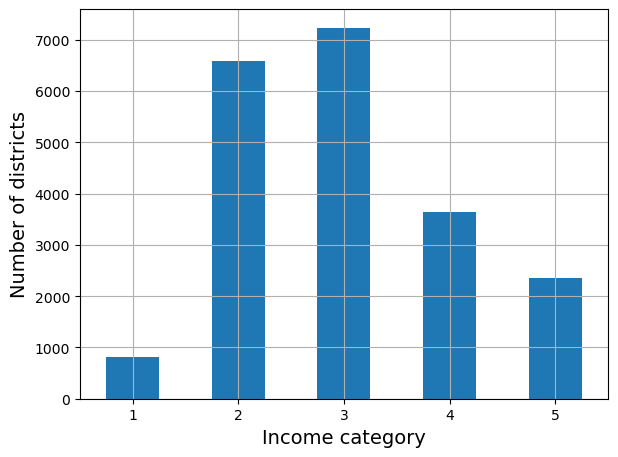

In [20]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [22]:
strat_train_set_n, strat_test_set_n = strat_splits[0]

It's much shorter to get a single stratified split:

In [23]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [25]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] -1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)

(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Discover and Visualize the Data to Gain Insights

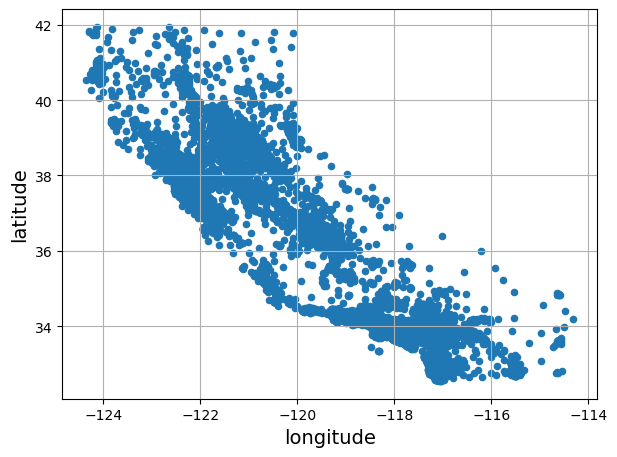

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

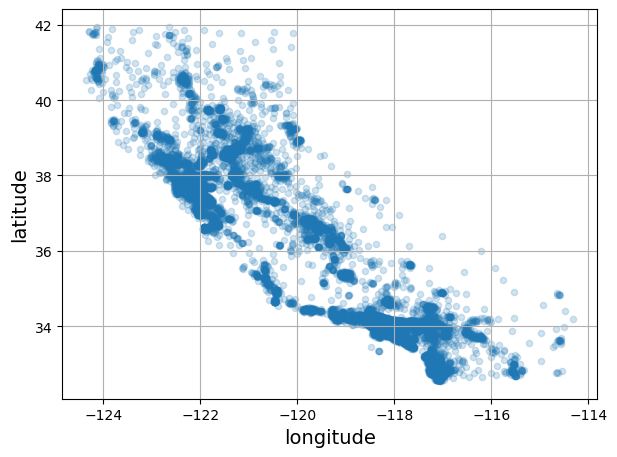

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")
plt.show()

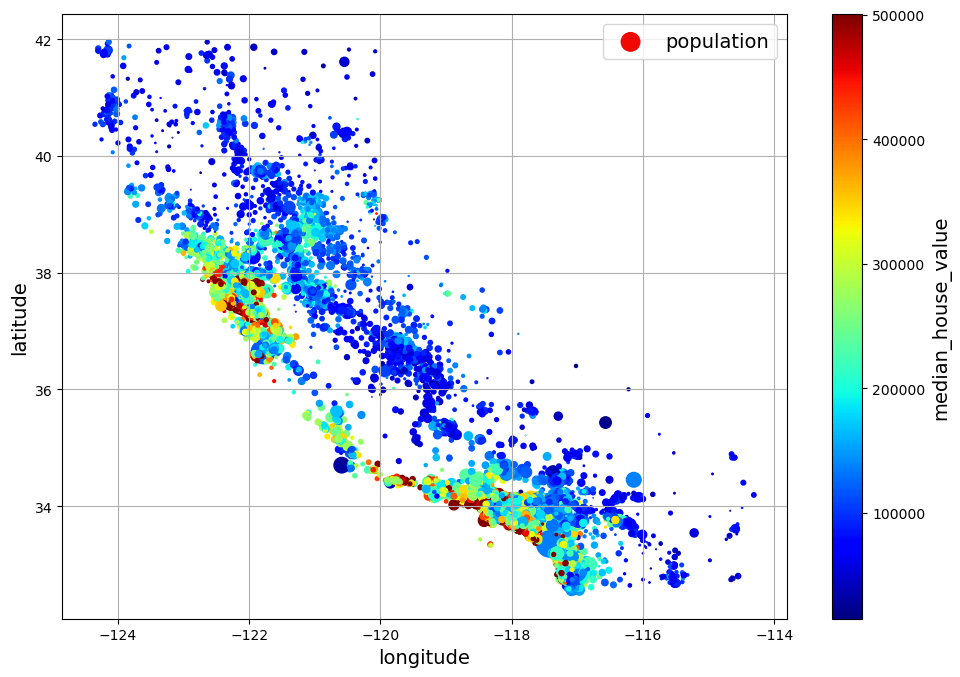

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100,
            label="population", c="median_house_value", cmap="jet",colorbar=True,
            legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_price_scatterplot")
plt.show()

*A beautified version of the previous figure, with an image of California added in the background, nicer label names and no grid.*

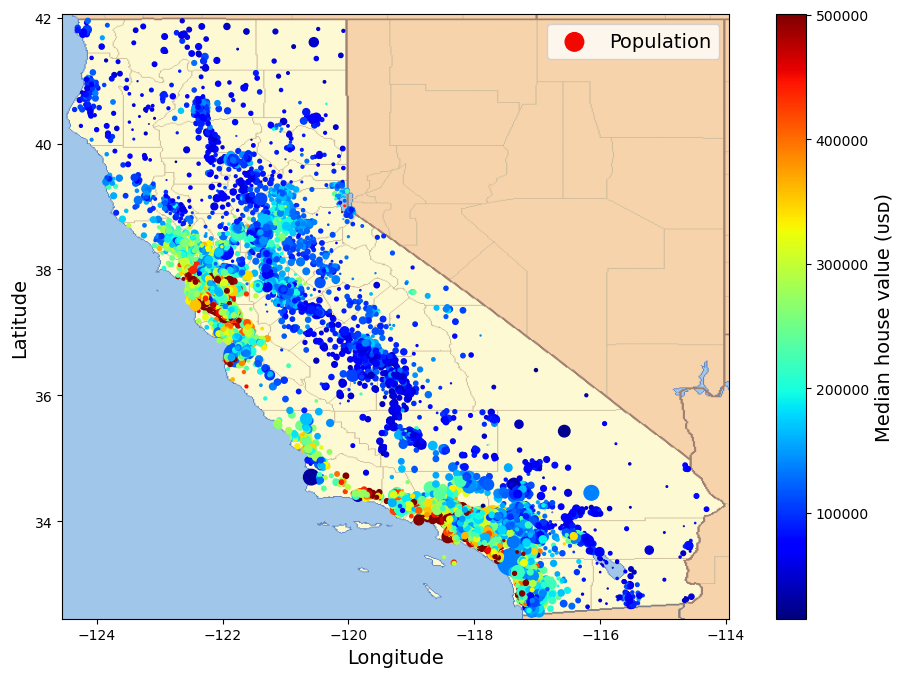

In [30]:
# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

#### Looking for Correlations

In [31]:
corr_matrix = housing.corr()

C:\Users\balde\AppData\Local\Temp\ipykernel_12416\2466220658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [32]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

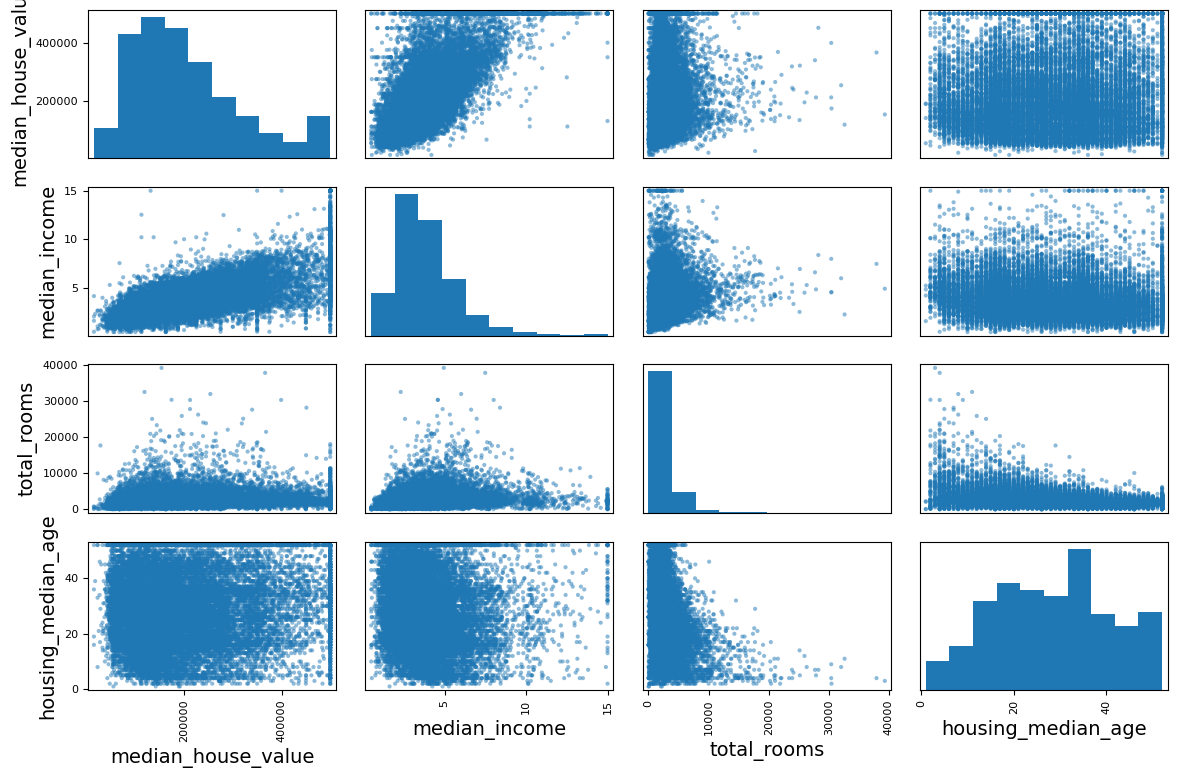

In [33]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
plt.show()

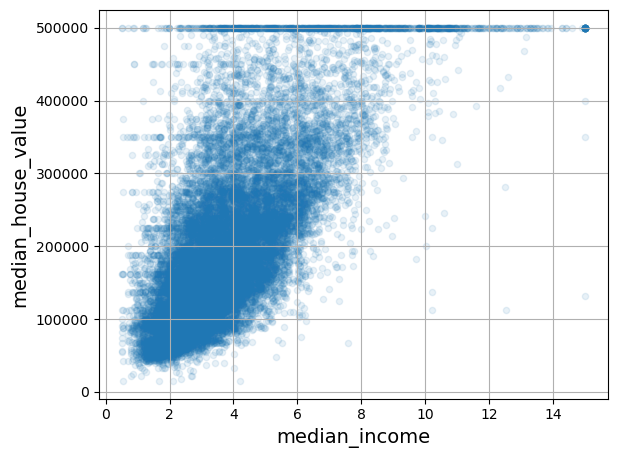

In [34]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")
plt.show()

#### Experimenting with Attribute Combinations

In [35]:
housing["rooms_per_house"] = housing["total_rooms"]/ housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [36]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

C:\Users\balde\AppData\Local\Temp\ipykernel_12416\826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithms


Let's revert to the original training set and separate the target(note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itsel, unless we pass `inplace=True`):

In [37]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Data Cleaning

In [38]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


We will handle the 3 options below  
* options 1: Remove the line with na (housing.dropna(subset=["total_bedrooms"], inplace=True))  
* option 2: remove the Column with na (housing.drop("total_bedrooms", axis=1) )  
* option 3: Replace the na with the median or mean (median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True))

In [39]:
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [40]:
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [41]:
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [43]:
housing_num = housing.select_dtypes(include=[np.number])

In [44]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [45]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [46]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [47]:
X = imputer.transform(housing_num)

In [48]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [49]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [50]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


* Now let's drop some outliers

In [51]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [52]:
# If you wanted to drop outliers, you would run the following code:

#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

### Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`

In [53]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [54]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [55]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [56]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder`class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [57]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, we can set `sparse=False`when creating the `OneHotEncoder`:

In [58]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [59]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [60]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [61]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [62]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [63]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [64]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [65]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0


### Feature Scaling

In [66]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [67]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

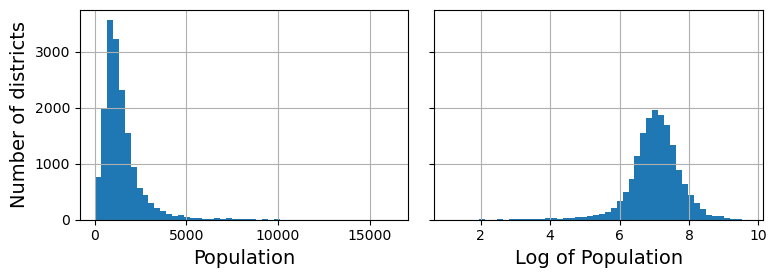

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of Population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

What if we replace each value with its percentile ?

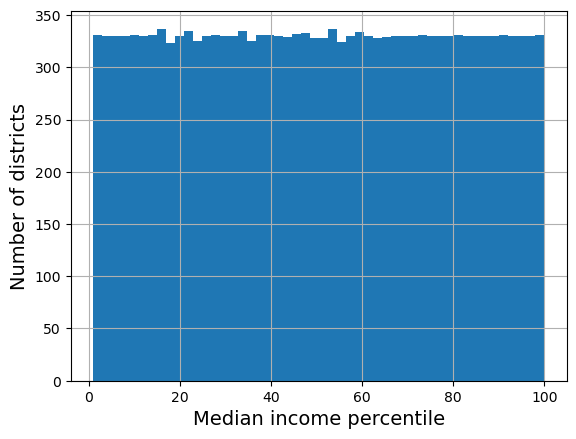

In [69]:
# Just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).


In [70]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

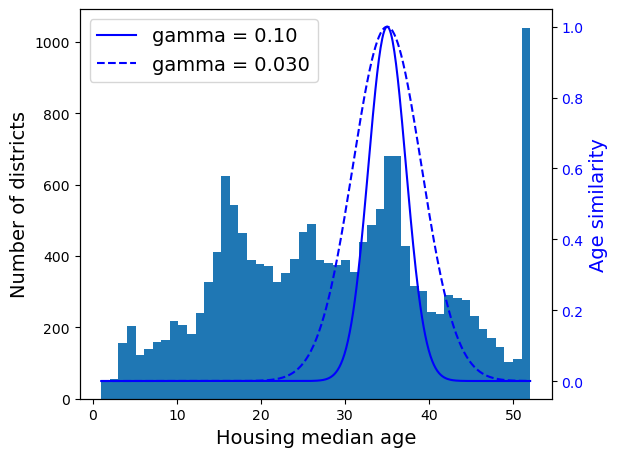

In [71]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()               # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.030", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()


In [72]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]         # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

print(predictions)

[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


In [73]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

#### Custom Transformers

To create simple transformers:

In [74]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop =  log_transformer.transform(housing[["population"]])

In [75]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [76]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [77]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [78]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)      # checks that X is an array with finite float value
        self.mean = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]   # every estimator stores this in fit()
        return self      # always return self!
    

    def transform(self, X):
        check_is_fitted(self)    # Looks for Learned attributes (with trailing_)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [80]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self   # always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    

In [81]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

similarities[:3].round(2)

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

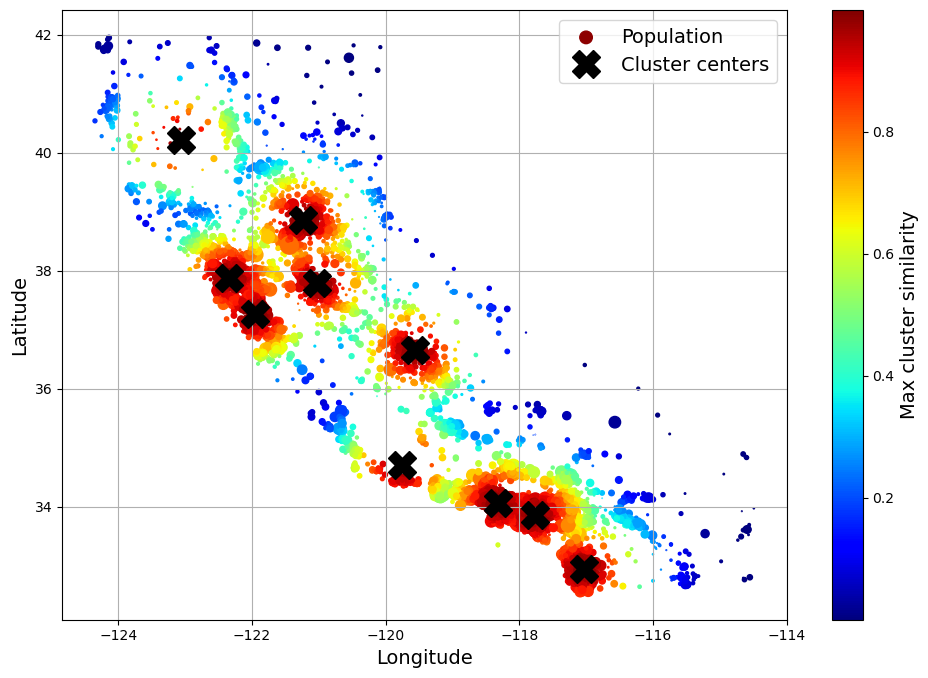

In [82]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s = housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity", cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20, label="Cluster centers")
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

#### Transformation Pipelines  

Now let's build a pipeline to preprocess the numerical attributes:

In [83]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [84]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [85]:
from sklearn import set_config

set_config(display='diagram')
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [86]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [87]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle_get_feature_names_out()
    correctly in Scikit-Learn"""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline, make_pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
            Parameter("feature_names_out", Parameter.KEYWORD_ONLY)
            ]
        )

        def get_feature_names_out(self, names=None):
            if callable(self.feature_name_out):
                return self.feature_name_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)
        
        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()


In [88]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index
)

df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [89]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [90]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [91]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [92]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [93]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)  
])

In [94]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=np.object)),
)

C:\Users\balde\AppData\Local\Temp\ipykernel_12416\1429372480.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (cat_pipeline, make_column_selector(dtype_include=np.object)),


In [95]:
housing_prepared = preprocessing.fit_transform(housing)

In [96]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)

housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [97]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]            # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil =  ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),      
],
    remainder=default_num_pipeline)    # one column remaining: housing_median_age

In [98]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [99]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Select and Train a Model

#### Training and Evaluating on the Training Set

In [100]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D4FAFAE7F0>)])),
                ('linearregression', LinearRegression())])

Let's try the full preprocessing pipeline on a few training instances:

In [101]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)       # -2 = rounded to the nearest hundred

array([243700., 372400., 128800.,  94400., 328300.])

Compare against the actual values:

In [102]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [103]:
# Compute the error ratios discussed in the book

error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values -1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.8%, -23.0%, 26.6%, -1.8%, -9.3%


In [104]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68687.89176590189

In [105]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D4FAFAE7F0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [106]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

#### Better Evaluation Using Cross-Validation

In [107]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [108]:
# Computes the error stats for the Linear model

lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

In [109]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

pd.Series(forest_rmses).describe()

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

count    1.000000e+01
mean     2.211801e+09
std      9.791604e+07
min      2.066440e+09
25%      2.158955e+09
50%      2.205955e+09
75%      2.239722e+09
max      2.424948e+09
dtype: float64

Let's compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set(the "training error"):

In [110]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17474.619286483998

The training error is much than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

### Fine-Tune Your Model

#### Grid Search

In [111]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
     {'preprocessing__geo__n_clusters': [10, 15],
      'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid=param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)



c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D4FAFAE7F0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

We can get the the full list of hyperparameters available for tuning by looking at `full_pipeline.get_params().keys`:

In [112]:
# Shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose'

The best hyperparameter combination found:

In [113]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [114]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001D...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D49519D460>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

Let's look at the score of each hyperparameter combination tested during the grid search:

In [115]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# make the dataframe look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]

cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


#### Randomize Search

In [116]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

Try 30 (`n_iter`*`cv`) random combinations of hyperparameters:

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D4F9BEEC70>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D495046D90>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [118]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41287,42071,42627,41995
8,32,7,41690,42513,43224,42475
0,41,16,42223,42959,43321,42834
5,42,4,41818,43094,43817,42910
2,23,8,42264,42996,43830,43030


### Analyze the Best Models and Their Errors

In [119]:
final_model = rnd_search.best_estimator_        # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [120]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.013489636258229071, 'geo__Cluster 3 similarity'),
 (0.013383196263838682, 'geo__Cluster 38 similarit

### Evaluate Our System on the Test Set

In [121]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

41424.40026462184

We can compute a 95% confidence interval for the test RMSE:

In [122]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39275.40861216, 43467.27680583])

We can compute the interval manually like this:

In [123]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39275.408612160776, 43467.2768058342)

Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:

In [124]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39276.05610140008, 43466.69174996963)

### Model persistence using Joblib  
  
Save the final model

In [125]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

Now we can deploy this model to production.  
For example, the following code could be a script that would run in production

In [126]:
import joblib

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]         # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
predictions

array([442737.15, 457566.06, 105965.  ,  98462.  , 332992.01])

### Exercice solutions

**Exercice1**  
*Try a Support Vector Machine regressor* (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so we should probably train our model on just the first 5.000 instances of the training set and use only 3-fold cross-validation, else it will take hours. How does the best `SVR` predictor perform ?

In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
    {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                           3000., 10000., 30000.0]},
    {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
     'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D4FAFAE7F0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

The best model achieves the following score (evaluated using 3-fold cross validation):

In [128]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

69814.13848127612

That's much worse than the `RandomForestRegressor` (but to be fair, we trained the model on much less data). Let's check the best hyperparameters found.

In [129]:
grid_search.best_params_

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better

**Exercice 2**  
*Try replacing the `GridSearchCV` with a `RandomizedSearchCV`*

In [130]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

# Note: gamma is ignored when kernel is "linear"

param_distribs = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': loguniform(20, 200_000),
    'svr__gamma': expon(scale=1.0),
}

rnd_search = RandomizedSearchCV(svr_pipeline, param_distributions=param_distribs, n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',random_state=42, verbose=2)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=629.782329591372, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=629.782329591372, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=629.782329591372, svr__gamma=3.010121430917521, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=26290.206464300216, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=26290.206464300216, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=26290.206464300216, svr__gamma=0.9084469696321253, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   1.4s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=84.14107900575871, svr__gamma=0.059838768608680676, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=432.37884813148855, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=432.37884813148855, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=432.37884813148855, svr__gamma=0.15416196746656105, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=24.17508294611391, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=24.17508294611391, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=24.17508294611391, svr__gamma=3.503557475158312, svr__kernel=rbf; total time=   1.4s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=113564.03940586245, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=113564.03940586245, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=113564.03940586245, svr__gamma=0.0007790692366582295, svr__kernel=rbf; total time=   1.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=108.30488238805073, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=108.30488238805073, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=108.30488238805073, svr__gamma=0.3627537294604771, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=21.344953672647435, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=21.344953672647435, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=21.344953672647435, svr__gamma=0.023332523598323388, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=5603.270317432516, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=5603.270317432516, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=5603.270317432516, svr__gamma=0.15023452872733867, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   2.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=157055.10989448498, svr__gamma=0.26497040005002437, svr__kernel=rbf; total time=   3.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=27652.464358739708, svr__gamma=0.2227358621286903, svr__kernel=linear; total time=   1.1s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=27652.464358739708, svr__gamma=0.2227358621286903, svr__kernel=linear; total time=   1.3s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=27652.464358739708, svr__gamma=0.2227358621286903, svr__kernel=linear; total time=   1.4s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=171377.39570378003, svr__gamma=0.628789100540856, svr__kernel=linear; total time=   2.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=171377.39570378003, svr__gamma=0.628789100540856, svr__kernel=linear; total time=   7.3s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=171377.39570378003, svr__gamma=0.628789100540856, svr__kernel=linear; total time=   3.3s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=5385.293820172355, svr__gamma=0.18696125197741642, svr__kernel=linear; total time=   1.1s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=5385.293820172355, svr__gamma=0.18696125197741642, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=5385.293820172355, svr__gamma=0.18696125197741642, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=22.59903216621323, svr__gamma=2.850796878935603, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=22.59903216621323, svr__gamma=2.850796878935603, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=22.59903216621323, svr__gamma=2.850796878935603, svr__kernel=rbf; total time=   1.4s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=34246.75194632794, svr__gamma=0.3632878599687583, svr__kernel=linear; total time=   1.2s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=34246.75194632794, svr__gamma=0.3632878599687583, svr__kernel=linear; total time=   1.2s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=34246.75194632794, svr__gamma=0.3632878599687583, svr__kernel=linear; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=167.7278956080511, svr__gamma=0.2757870542258224, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=167.7278956080511, svr__gamma=0.2757870542258224, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=167.7278956080511, svr__gamma=0.2757870542258224, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=61.54360542501371, svr__gamma=0.6835472281341501, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=61.54360542501371, svr__gamma=0.6835472281341501, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=61.54360542501371, svr__gamma=0.6835472281341501, svr__kernel=linear; total time=   0.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=98.73897389920914, svr__gamma=0.4960365360493639, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=98.73897389920914, svr__gamma=0.4960365360493639, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=98.73897389920914, svr__gamma=0.4960365360493639, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=8935.505635947808, svr__gamma=0.37354658165762367, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=8935.505635947808, svr__gamma=0.37354658165762367, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=8935.505635947808, svr__gamma=0.37354658165762367, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=135.76775824842434, svr__gamma=0.838636245624803, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=135.76775824842434, svr__gamma=0.838636245624803, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=135.76775824842434, svr__gamma=0.838636245624803, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=151136.20282548846, svr__gamma=1.4922453771381408, svr__kernel=rbf; total time=   2.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=151136.20282548846, svr__gamma=1.4922453771381408, svr__kernel=rbf; total time=   2.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=151136.20282548846, svr__gamma=1.4922453771381408, svr__kernel=rbf; total time=   2.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=761.4316758498783, svr__gamma=2.6126336514161914, svr__kernel=linear; total time=   0.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=761.4316758498783, svr__gamma=2.6126336514161914, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=761.4316758498783, svr__gamma=2.6126336514161914, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=97392.81883041795, svr__gamma=0.09265545895311562, svr__kernel=linear; total time=   2.2s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=97392.81883041795, svr__gamma=0.09265545895311562, svr__kernel=linear; total time= 1.6min


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=97392.81883041795, svr__gamma=0.09265545895311562, svr__kernel=linear; total time=   2.1s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=2423.0759984939164, svr__gamma=3.248614270240346, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=2423.0759984939164, svr__gamma=3.248614270240346, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=2423.0759984939164, svr__gamma=3.248614270240346, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=717.3632997255095, svr__gamma=0.3165604432088257, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=717.3632997255095, svr__gamma=0.3165604432088257, svr__kernel=linear; total time=   0.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=717.3632997255095, svr__gamma=0.3165604432088257, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=4446.667521184072, svr__gamma=3.3597284456608496, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=4446.667521184072, svr__gamma=3.3597284456608496, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=4446.667521184072, svr__gamma=3.3597284456608496, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=2963.564121207815, svr__gamma=0.15189814782062885, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=2963.564121207815, svr__gamma=0.15189814782062885, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=2963.564121207815, svr__gamma=0.15189814782062885, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=91.64267381686706, svr__gamma=0.01575994483585621, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=91.64267381686706, svr__gamma=0.01575994483585621, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=91.64267381686706, svr__gamma=0.01575994483585621, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=24547.601975705915, svr__gamma=0.22153944050588595, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=24547.601975705915, svr__gamma=0.22153944050588595, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=24547.601975705915, svr__gamma=0.22153944050588595, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=22.76927941060928, svr__gamma=0.22169760231351215, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=22.76927941060928, svr__gamma=0.22169760231351215, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=22.76927941060928, svr__gamma=0.22169760231351215, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=16483.850529752886, svr__gamma=1.4752145260435134, svr__kernel=linear; total time=   1.1s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=16483.850529752886, svr__gamma=1.4752145260435134, svr__kernel=linear; total time=   1.4s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=16483.850529752886, svr__gamma=1.4752145260435134, svr__kernel=linear; total time=   1.1s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=101445.66881340064, svr__gamma=1.052904084582266, svr__kernel=rbf; total time=   2.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=101445.66881340064, svr__gamma=1.052904084582266, svr__kernel=rbf; total time=   2.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=101445.66881340064, svr__gamma=1.052904084582266, svr__kernel=rbf; total time=   2.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=56681.80859029545, svr__gamma=0.9763011917123741, svr__kernel=rbf; total time=   2.4s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=56681.80859029545, svr__gamma=0.9763011917123741, svr__kernel=rbf; total time=   2.0s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=56681.80859029545, svr__gamma=0.9763011917123741, svr__kernel=rbf; total time=   2.0s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=48.15822390928914, svr__gamma=0.4633351167983427, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=48.15822390928914, svr__gamma=0.4633351167983427, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=48.15822390928914, svr__gamma=0.4633351167983427, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=399.7268155705774, svr__gamma=1.3078757839577408, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=399.7268155705774, svr__gamma=1.3078757839577408, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=399.7268155705774, svr__gamma=1.3078757839577408, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=251.14073886281363, svr__gamma=0.8238105204914145, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=251.14073886281363, svr__gamma=0.8238105204914145, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=251.14073886281363, svr__gamma=0.8238105204914145, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=60.17373642891687, svr__gamma=1.2491263443165994, svr__kernel=linear; total time=   0.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=60.17373642891687, svr__gamma=1.2491263443165994, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=60.17373642891687, svr__gamma=1.2491263443165994, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=15415.161544891856, svr__gamma=0.2691677514619319, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=15415.161544891856, svr__gamma=0.2691677514619319, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=15415.161544891856, svr__gamma=0.2691677514619319, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=1888.9148509967113, svr__gamma=0.739678838777267, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=1888.9148509967113, svr__gamma=0.739678838777267, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=1888.9148509967113, svr__gamma=0.739678838777267, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=55.53838911232773, svr__gamma=0.578634378499143, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=55.53838911232773, svr__gamma=0.578634378499143, svr__kernel=linear; total time=   0.7s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=55.53838911232773, svr__gamma=0.578634378499143, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=26.714480823948186, svr__gamma=1.0117295509275495, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=26.714480823948186, svr__gamma=1.0117295509275495, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=26.714480823948186, svr__gamma=1.0117295509275495, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=3582.0552780489566, svr__gamma=1.1891370222133257, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=3582.0552780489566, svr__gamma=1.1891370222133257, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=3582.0552780489566, svr__gamma=1.1891370222133257, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=198.7004781812736, svr__gamma=0.5282819748826726, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=198.7004781812736, svr__gamma=0.5282819748826726, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=198.7004781812736, svr__gamma=0.5282819748826726, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=129.8000604143307, svr__gamma=2.8621383676481322, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=129.8000604143307, svr__gamma=2.8621383676481322, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=129.8000604143307, svr__gamma=2.8621383676481322, svr__kernel=linear; total time=   0.8s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=288.4269299593897, svr__gamma=0.17580835850006285, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=288.4269299593897, svr__gamma=0.17580835850006285, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=288.4269299593897, svr__gamma=0.17580835850006285, svr__kernel=rbf; total time=   1.5s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=6287.039489427172, svr__gamma=0.3504567255332862, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=6287.039489427172, svr__gamma=0.3504567255332862, svr__kernel=linear; total time=   0.9s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=6287.039489427172, svr__gamma=0.3504567255332862, svr__kernel=linear; total time=   1.0s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=61217.04421344494, svr__gamma=1.6279689407405564, svr__kernel=rbf; total time=   2.1s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=61217.04421344494, svr__gamma=1.6279689407405564, svr__kernel=rbf; total time=   2.0s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=61217.04421344494, svr__gamma=1.6279689407405564, svr__kernel=rbf; total time=   2.1s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=926.9787684096649, svr__gamma=2.147979593060577, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=926.9787684096649, svr__gamma=2.147979593060577, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=926.9787684096649, svr__gamma=2.147979593060577, svr__kernel=rbf; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=33946.157064934, svr__gamma=2.2642426492862313, svr__kernel=linear; total time=   1.3s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=33946.157064934, svr__gamma=2.2642426492862313, svr__kernel=linear; total time=   1.4s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=33946.157064934, svr__gamma=2.2642426492862313, svr__kernel=linear; total time=   1.6s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=84789.82947739525, svr__gamma=0.3176359085304841, svr__kernel=linear; total time=   2.2s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=84789.82947739525, svr__gamma=0.3176359085304841, svr__kernel=linear; total time=   2.0s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END svr__C=84789.82947739525, svr__gamma=0.3176359085304841, svr__kernel=linear; total time=   2.3s


c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001D4FAFAE7F0>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D4F9B1F610>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D49507A490>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

The best model achieves the following score (evaluated using 3-fold cross-validation):

In [132]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse 

55853.88100363906

Now that's really much better, but still far from the `RandomForestRegressor`s performance. Let's check the best hyperparameters found:

In [133]:
rnd_search.best_params_

{'svr__C': 157055.10989448498,
 'svr__gamma': 0.26497040005002437,
 'svr__kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel.  
Randomized search tends to find better hyperparameters than grid search in the same amount of time.  
  
Note that we used the `expon()` distribution for `gamma`, with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [134]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)       # get 100000 samples
((s > 0.105) & (s < 2.29)).sum() / 100_000

0.80066

We used the `loguniform()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2000 to 20000 or from 20000 to 200000.

**Exercice 3**  
*Try adding a `SelectFromModel`* transformer in the preparation pipeline to select only the most important attributes.  

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a `SelectFromModel` transformer based on a `RandomForestRegressor` before the final regressor.

In [137]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [138]:
selector_rmse = -cross_val_score(selector_pipeline,
                                 housing.iloc[:5000],
                                 housing_labels.iloc[:5000],
                                 scoring="neg_root_mean_squared_error",
                                 cv=3)
pd.Series(selector_rmse).describe()

c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\balde\Anaconda3\envs\env_handson_ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


count        3.000000
mean     56211.362089
std       1922.002815
min      54150.008611
25%      55339.929912
50%      56529.851213
75%      57242.038829
max      57954.226445
dtype: float64

Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tunning it using random search or grid search ?

**Exercice 4**  
*Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts.*  
  
Rather than restric ourselves to k-Nearest Neighbors regressor, let's create a transformer that accepts any regressor. For this, we can extend the `MetaEstimatorMixin` and have a required `estimator` argument in the constructor.  
The `fit()` method must work on a clone of this estimator, and it must also save `feature_names_in_`. The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning. Lastly, we create a `get_feature_names_out()` method: the output column name is the ...

In [142]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone

class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        estimator_ = clone(self.estimator)
        estimator_.fit(X, y)
        self.estimator_ = estimator_
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator, "feature_names_in_"):
            self.feature_names_in_ = self.estimator.feature_names_in_
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
                for i in range(n_outputs)]

Let's ensure it complies to Scikit-Learn's API:

In [143]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

Good! Now let's test it:

In [144]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[486100.66666667],
       [435250.        ],
       [105100.        ],
       ...,
       [148800.        ],
       [500001.        ],
       [234333.33333333]])

And what does its output feature name look like ?

In [145]:
knn_transformer.get_feature_names_out()

['kneighborsregressor_prediction_0']

Okay, now let's include this transformer in our preprocessing pipeline:

In [148]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns) for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _ , _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [151]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [152]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error", cv=3)
pd.Series(new_pipe_rmses).describe()

count         3.000000
mean     105035.426084
std        2918.386386
min      101812.943805
25%      103802.990253
50%      105793.036701
75%      106646.667223
max      107500.297745
dtype: float64

Yikes, that's terrible! Apparently the cluster similarity features were much better. But perhaps we should tune the `KNeighborsRegressor`'s hyperparameters? That's what the next step is 

**Exercice 5**  
*Automatically explore some preparation options using `RandomSearchCV`

In [153]:
param_distribs = {
    "preprocessing__geo__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo__estimator__weights": ["distance", "uniform"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distributions=param_distribs,
                                        n_iter=50, cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)
new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels[:5000])

C:\Users\balde\AppData\Local\Temp\ipykernel_12416\1521063789.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels[:5000])


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x000001D4993CD430>,
                                                                                                                    func=<function column_ratio at 0x000001D4993F9790>)),
                                                                                               ('standardscaler',
                                                                                                St...
                   param_distributions={'preprocessing__geo__estimator__n_neighbors': range(1, 30),
                                        'preprocessing__geo__estimator__weights': ['distance',
                                                                                   'uniform'],
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D497D9DC10>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D497CC62B0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [154]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

106867.29187763127

Oh well... at least we tried! It looks like the cluster similarity features are definitely better than the KNN feature. But perhaps you could try having both? And maybe training on the full training set would help as well.

**Exercice 6**  
*Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names.  
Lastly, implement the `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches *n_features_in_* and it should match *feature_names_in_* if it is defined, then *input_features* should be returned. If *input_features* is *None*, then the method should return *feature_names_in_* if it is defined or np.array(["x0", "x1", ...]) with length *n_features_in_* otherwise.

In [158]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array


class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X_orig = X
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        if hasattr(X_orig, "columns"):
            self.feature_names_in_ = np.array(X_orig.columns, dtype=object)
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.n_features_in_ != X.shape[1]:
            raise ValueError("Unexpected number of features")
        X = X * self.scale_
        return X + self.mean_ if self.with_mean else X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

Let's test our custom transformer:

In [159]:
from sklearn.utils.estimator_checks import check_estimator
 
check_estimator(StandardScalerClone())

No errors, that's great start, we respect the Scikit-Learn API.  
  
Now let's ensure the transformation works as expected:

In [160]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))


How about setting `with_mean=False` ?

In [161]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))


And does the inverse work ?

In [162]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

How about the feature names out?

In [163]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])


And if we fit a DataFrame, are the feature in and out ok?

In [164]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])